# Wildfire Data Extraction and Analysis

#

In [1]:
import os
from datetime import datetime
import pandas as pd
import numpy as np
from pyproj import Transformer, Geod
import geojson
import re
import matplotlib.pyplot as plt
from pathlib import Path

class FireImpactAnalyzer:
    def __init__(self, location_name, location_coords, analysis_start=1961, analysis_end=2021, verbose=False):
        """
        Initialize the analyzer with location details and analysis range.
        
        Args:
            location_name (str): Name of the target location
            location_coords (tuple): (latitude, longitude) of the target location
            analysis_start (int): Initial year of analysis range
            analysis_end (int): Final year of analysis range
            verbose (bool): Enable detailed logging if True
        """
        self.location_name = location_name
        self.location_coords = location_coords
        self.analysis_start = analysis_start
        self.analysis_end = analysis_end
        self.max_radius = 650  # miles
        self.season_start = 5  # May
        self.season_end = 10   # October
        self.verbose = verbose
        
        # Set up geodesic distance calculator with WGS84 ellipsoid
        self.geodetic_calculator = Geod(ellps='WGS84')
        
        # Set up coordinate transformation
        self.to_wgs84 = Transformer.from_crs("ESRI:102008", "EPSG:4326")
        
        # Initialize tracking counters for debugging
        self.total_processed = 0
        self.total_errors = 0
        self.total_skipped = 0
        
        # Regular expression for date extraction
        self.date_pattern = r"Listed Wildfire Discovery Date\(s\): ([^|]+)"

    def log_verbose(self, message):
        """Output verbose log messages if enabled."""
        if self.verbose:
            print(f"LOG: {message}")

    def parse_earliest_discovery_date(self, date_text):
        """
        Retrieve the earliest date from the provided discovery date text.
        
        Args:
            date_text (str): Text with discovery dates information
            
        Returns:
            str: Earliest date in MM/DD/YYYY format or None if parsing fails
        """
        try:
            if not date_text:
                return None
                
            # Extract discovery dates section
            match = re.search(self.date_pattern, date_text)
            if not match:
                return None
                
            # Find all date matches within the extracted section
            discovery_dates = match.group(1)
            matched_dates = re.findall(r'(\d{4}-\d{2}-\d{2})', discovery_dates)
            
            if not matched_dates:
                return None
                
            # Convert to datetime objects and get the earliest one
            parsed_dates = [datetime.strptime(d, '%Y-%m-%d') for d in matched_dates]
            earliest_date = min(parsed_dates)
            
            # Format as MM/DD/YYYY
            return earliest_date.strftime('%m/%d/%Y')
            
        except Exception as e:
            self.log_verbose(f"Date parsing error: {str(e)}")
            return None

    def validate_fire_data(self, fire):
        """
        Verify structure and required attributes of fire data.
        
        Args:
            fire (dict): Fire feature from GeoJSON data
            
        Returns:
            bool: True if feature structure is valid
        """
        try:
            # Check structure type
            if not isinstance(fire, dict):
                self.log_verbose("Invalid structure: Not a dictionary")
                return False
                
            # Confirm necessary fields are present
            if 'attributes' not in fire:
                self.log_verbose("Missing attributes")
                return False
                
            if 'geometry' not in fire:
                self.log_verbose("Missing geometry")
                return False
                
            # Confirm essential attributes are present
            required_fields = ['Fire_Year', 'GIS_Acres', 'Listed_Fire_Names', 
                            'Assigned_Fire_Type', 'Listed_Fire_Dates']
            for field in required_fields:
                if field not in fire['attributes']:
                    self.log_verbose(f"Missing required field: {field}")
                    return False
                    
            # Validate geometry structure
            if 'rings' not in fire['geometry'] and 'curveRings' not in fire['geometry']:
                self.log_verbose("Geometry missing rings or curveRings")
                return False
                
            return True
            
        except Exception as e:
            self.log_verbose(f"Validation error: {str(e)}")
            return False

    def transform_to_wgs84(self, coords):
        """
        Convert coordinates from ESRI:102008 to EPSG:4326.
        
        Args:
            coords (list): Coordinate pairs in ESRI:102008 format
        
        Returns:
            list: Coordinates in EPSG:4326 format
        """
        transformed_coords = []
        try:
            for coord in coords:
                if len(coord) >= 2:  # Ensure coord has latitude and longitude
                    lat, lon = self.to_wgs84.transform(coord[0], coord[1])
                    transformed_coords.append((lat, lon))
        except Exception as e:
            self.log_verbose(f"Coordinate transformation error: {str(e)}")
        return transformed_coords

    def compute_distance_to_city(self, perimeter_coords):
        """
        Find the shortest distance from fire perimeter to target location.
        
        Args:
            perimeter_coords (list): List of perimeter coordinate pairs
            
        Returns:
            float: Distance in miles, or None if computation fails
        """
        try:
            if not perimeter_coords:
                return None
                
            distances = []
            location_lon, location_lat = self.location_coords[1], self.location_coords[0]
            
            for coord in perimeter_coords:
                dist = self.geodetic_calculator.inv(location_lon, location_lat, coord[1], coord[0])
                dist_miles = dist[2] * 0.00062137  # Convert meters to miles
                distances.append(dist_miles)
                
            return min(distances) if distances else None
            
        except Exception as e:
            self.log_verbose(f"Distance calculation error: {str(e)}")
            return None

    def compute_smoke_impact(self, size_acres, distance_miles):
        """
        Compute the smoke impact score considering fire size and proximity.
        
        Args:
            size_acres (float): Fire area in acres
            distance_miles (float): Distance to location in miles
            
        Returns:
            float: Smoke impact score
        """
        try:
            if distance_miles is None or distance_miles <= 0 or size_acres <= 0:
                return 0
                
            # Constants for impact calculation
            SIZE_SCALE = 1e5  # Scale factor for fire size
            DISTANCE_THRESHOLD = 250  # Max distance for high impact
            MAX_DISTANCE = 650  # Max distance for analysis
            
            # Scale fire size with cube root for balance
            size_normalized = (size_acres / SIZE_SCALE) ** (1/3)
            
            # Define impact factor based on distance
            if distance_miles <= DISTANCE_THRESHOLD:
                distance_factor = 1.0
            else:
                # Scale linearly beyond threshold
                distance_factor = max(0, 1 - (distance_miles - DISTANCE_THRESHOLD) / (MAX_DISTANCE - DISTANCE_THRESHOLD))
            
            # Base impact calculation
            impact_score = size_normalized * distance_factor
            
            # Boost impact for large fires
            if size_acres > 100000:
                impact_score += 0.05
                
            return impact_score
            
        except Exception as e:
            self.log_verbose(f"Impact calculation error: {str(e)}")
            return 0

    def check_fire_season(self, date_str):
        """
        Determine if a date falls within the defined fire season (May - October).
        
        Args:
            date_str (str): Date in MM/DD/YYYY format
            
        Returns:
            bool: True if date is within fire season
        """
        if not date_str:
            return True  # Include fire if no date provided
            
        try:
            date = datetime.strptime(date_str, '%m/%d/%Y')
            return self.season_start <= date.month <= self.season_end
        except:
            self.log_verbose(f"Error parsing date: {date_str}")
            return True  # Include fire if parsing fails

    def analyze_fire_feature(self, fire):
        """
        Analyze a fire feature for criteria and calculate its impact.
        
        Args:
            fire (dict): GeoJSON fire feature
            
        Returns:
            dict: Analysis data or None if not meeting criteria
        """
        self.total_processed += 1
        
        try:
            # Validate feature structure
            if not self.validate_fire_data(fire):
                self.total_skipped += 1
                return None
                
            attributes = fire['attributes']
            
            # Exclude non-wildfires
            if attributes['Assigned_Fire_Type'] != 'Wildfire':
                self.total_skipped += 1
                self.log_verbose("Skipping non-wildfire feature")
                return None
            
            # Confirm year within analysis range
            year = attributes['Fire_Year']
            if not (self.analysis_start <= year <= self.analysis_end):
                self.total_skipped += 1
                return None
                
            # Parse and check discovery date
            discovery_date = self.parse_earliest_discovery_date(attributes['Listed_Fire_Dates'])
            if discovery_date and not self.check_fire_season(discovery_date):
                self.total_skipped += 1
                self.log_verbose(f"Fire outside season: {discovery_date}")
                return None
            
            # Retrieve perimeter coordinates
            ring_data = fire['geometry'].get('rings') or fire['geometry'].get('curveRings')
            if not ring_data:
                self.total_skipped += 1
                return None
                
            # Transform and compute distance
            transformed_coords = self.transform_to_wgs84(ring_data[0])
            if not transformed_coords:
                self.total_skipped += 1
                return None
                
            distance = self.compute_distance_to_city(transformed_coords)
            if distance is None or distance > self.max_radius:
                self.total_skipped += 1
                return None
                
            # Calculate smoke impact
            fire_size = attributes['GIS_Acres']
            smoke_impact_score = self.compute_smoke_impact(fire_size, distance)
            
            # Get main fire name
            fire_name = attributes['Listed_Fire_Names'].split(',')[0].strip()
            if '(' in fire_name:
                fire_name = fire_name.split('(')[0].strip()
            
            return {
                'year': year,
                'name': fire_name,
                'acres_burned': fire_size,
                'distance': distance,
                'smoke_impact_score': smoke_impact_score,
                'discovery_date': discovery_date
            }
            
        except Exception as e:
            self.total_errors += 1
            self.log_verbose(f"Error processing fire: {str(e)}")
            return None

    def evaluate_all_fires(self, fires):
        """
        Analyze multiple fire features and calculate annual impacts.
        
        Args:
            fires (list): List of fire features from GeoJSON data
            
        Returns:
            pd.DataFrame: Summary of annual fire impacts
        """
        results = []
        
        # Reset counters
        self.total_processed = 0
        self.total_errors = 0
        self.total_skipped = 0
        
        for fire in fires:
            result = self.analyze_fire_feature(fire)
            if result:
                results.append(result)
        
        print(f"\nAnalysis Summary:")
        print(f"Fires processed: {self.total_processed}")
        print(f"Fires included: {len(results)}")
        print(f"Fires skipped: {self.total_skipped}")
        print(f"Errors: {self.total_errors}\n")
        
        # Convert results to DataFrame
        if not results:
            print("No fires met analysis criteria!")
            return pd.DataFrame()
            
        df = pd.DataFrame(results)
        
        # Calculate yearly summaries
        annual_summary = df.groupby('year').agg({
            'acres_burned': ['count', 'sum'],
            'smoke_impact_score': 'sum',
            'distance': 'mean'
        }).round(2)
        
        # Rename columns
        annual_summary.columns = [
            'fire_count', 'total_acres_burned', 'total_smoke_impact', 'avg_distance'
        ]
        
        return annual_summary.sort_index()

    def visualize_results(self, annual_summary, output_dir=None):
        """
        Generate plots for analysis results.
        
        Args:
            annual_summary (pd.DataFrame): Analysis summary data
            output_dir (str): Directory to save plots (optional)
        """
        try:
            fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
            fig.suptitle(f'Fire Analysis for {self.location_name} ({self.analysis_start}-{self.analysis_end})')

            # Plot fire counts by year
            annual_summary['fire_count'].plot(ax=ax1, kind='bar')
            ax1.set_title('Annual Fire Count')
            ax1.set_xlabel('Year')
            ax1.set_ylabel('Count')
            ax1.tick_params(axis='x', rotation=45)

            # Plot total acres burned by year
            annual_summary['total_acres_burned'].plot(ax=ax2, kind='bar')
            ax2.set_title('Acres Burned per Year')
            ax2.set_xlabel('Year')
            ax2.set_ylabel('Acres')
            ax2.tick_params(axis='x', rotation=45)

            # Plot smoke impact score by year
            annual_summary['total_smoke_impact'].plot(ax=ax3, kind='bar')
            ax3.set_title('Smoke Impact Score')
            ax3.set_xlabel('Year')
            ax3.set_ylabel('Impact Score')
            ax3.tick_params(axis='x', rotation=45)

            # Plot average distance to fires by year
            annual_summary['avg_distance'].plot(ax=ax4, kind='bar')
            ax4.set_title('Average Fire Distance')
            ax4.set_xlabel('Year')
            ax4.set_ylabel('Miles')
            ax4.tick_params(axis='x', rotation=45)

            plt.tight_layout()

            if output_dir:
                output_path = Path(output_dir) / f'fire_analysis_{self.location_name.lower()}.png'
                plt.savefig(output_path)
                print(f"Saved plots to {output_path}")

            plt.show()

        except Exception as e:
            print(f"Error generating plots: {str(e)}")


# Fetching API Data for Olathe Location

Defining the City coordinates and saving the results in the fire_analysis_results.csv file. Along side plotting the visualizations to understand the created dataset better.

Starting analysis setup...
Data loaded successfully. Validating and analyzing...
LOG: Fire outside season: 11/06/1961
LOG: Fire outside season: 12/31/1961
LOG: Fire outside season: 11/13/1961
LOG: Fire outside season: 12/31/1961
LOG: Fire outside season: 01/19/1961
LOG: Fire outside season: 12/31/1961
LOG: Fire outside season: 12/31/1961
LOG: Fire outside season: 01/15/1961
LOG: Fire outside season: 11/13/1961
LOG: Fire outside season: 12/31/1961
LOG: Fire outside season: 12/31/1961
LOG: Fire outside season: 04/22/1961
LOG: Fire outside season: 12/31/1961
LOG: Fire outside season: 01/01/1961
LOG: Fire outside season: 02/24/1961
LOG: Fire outside season: 12/31/1961
LOG: Fire outside season: 12/31/1961
LOG: Fire outside season: 12/31/1961
LOG: Fire outside season: 11/04/1961
LOG: Fire outside season: 12/31/1961
LOG: Fire outside season: 12/31/1961
LOG: Fire outside season: 04/15/1961
LOG: Fire outside season: 12/31/1961
LOG: Fire outside season: 11/16/1961
LOG: Fire outside season: 01/01

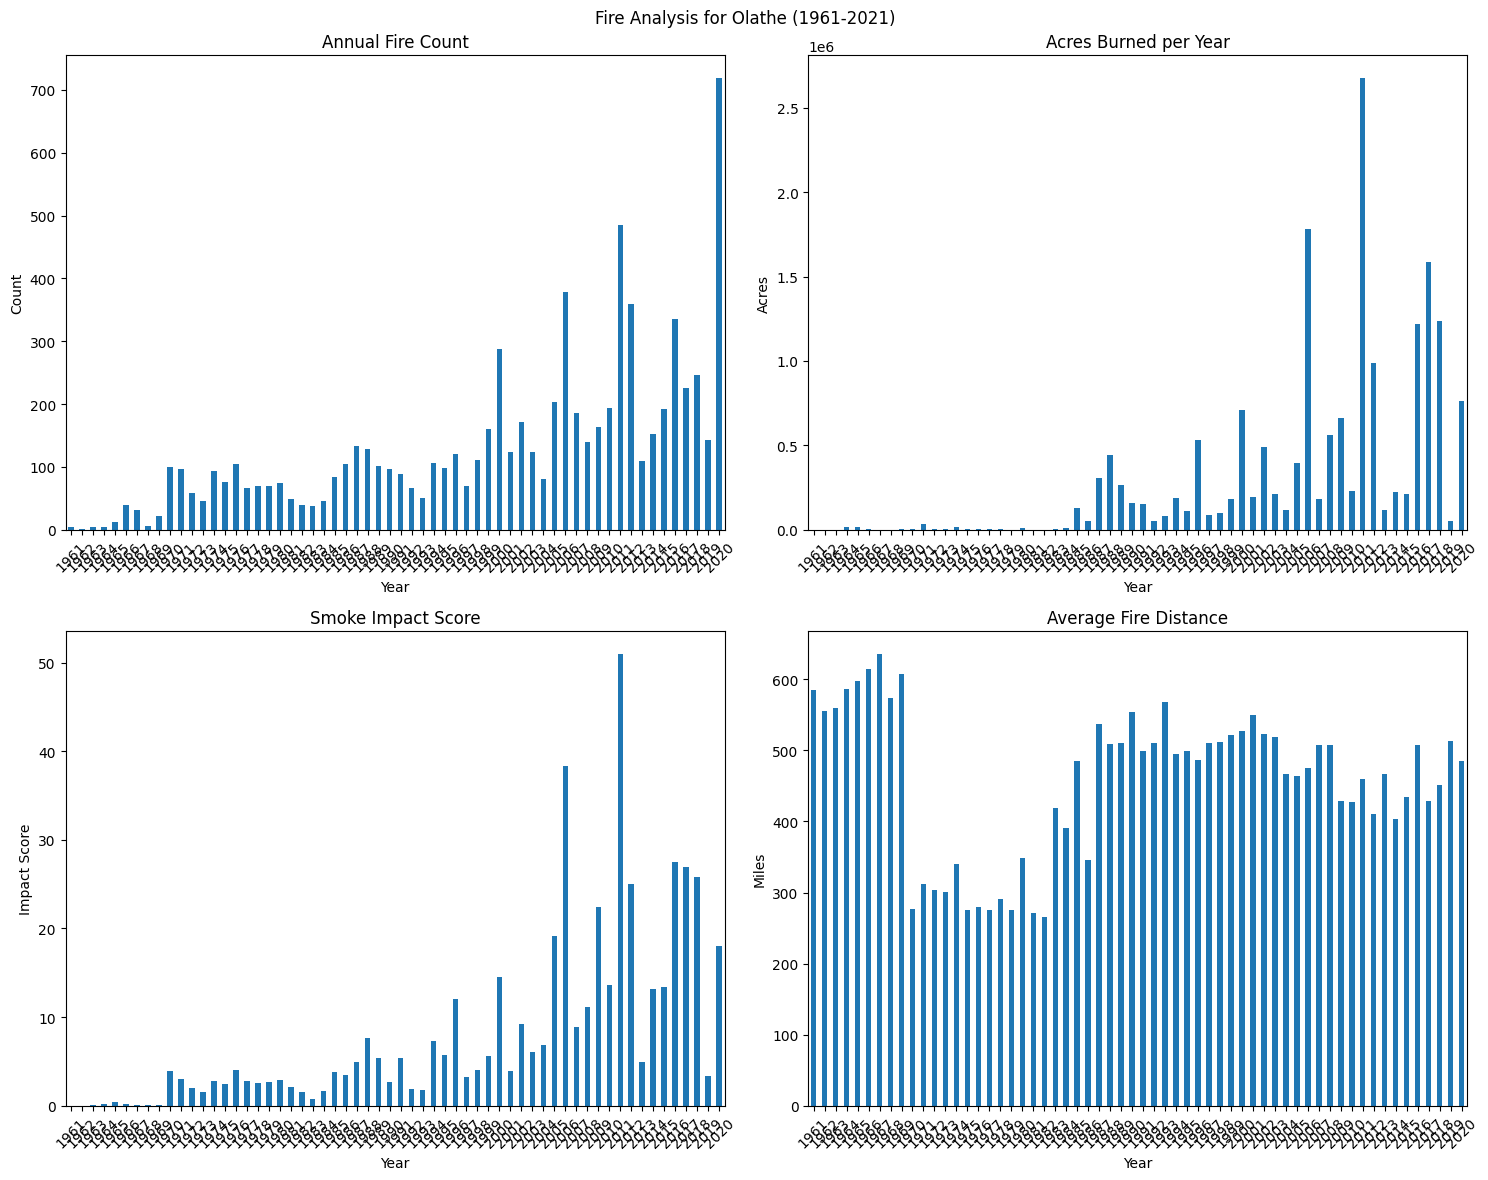

In [3]:

# Configuration for analysis
target_location = {
    'city': 'Olathe',
    'coordinates': (38.88, -94.82)  # latitude and longitude for Olathe
}

# Instantiate the analyzer with logging enabled
fire_analyzer = FireImpactAnalyzer(
    location_name=target_location['city'],
    location_coords=target_location['coordinates'],
    verbose=True
)

# Output directory for analysis artifacts
output_dir = 'fire_analysis_results'
os.makedirs(output_dir, exist_ok=True)

# Define input file path
input_geojson_file = 'USGS_Wildland_Fire_Combined_Dataset.json'

def load_geojson(filepath):
    """Load and return GeoJSON data from file."""
    try:
        with open(filepath, 'r') as file:
            return geojson.load(file)
    except FileNotFoundError:
        print(f"Error: File {filepath} not found. Please ensure it exists in the specified location.")
        return None

# Pre-load data
print("Starting analysis setup...")
wildfire_data = load_geojson(input_geojson_file)

# Validate and analyze data
if wildfire_data and 'features' in wildfire_data:
    print("Data loaded successfully. Validating and analyzing...")
    yearly_summary = fire_analyzer.evaluate_all_fires(wildfire_data['features'])
    
    # Post-analysis: Check if any data meets criteria
    if not yearly_summary.empty:
        # Display summary of parameters and results
        print(f"\n--- Fire Impact Summary for {target_location['city']} ---")
        print(f"Years: {fire_analyzer.analysis_start}-{fire_analyzer.analysis_end}")
        print(f"Distance Cap: {fire_analyzer.max_radius} miles")
        print(f"Active Fire Season: May to October\n")
        print(yearly_summary)

        # Saving results as CSV
        csv_filepath = os.path.join(
            output_dir, 
            f"{target_location['city'].lower()}_fire_impact_{fire_analyzer.analysis_start}_{fire_analyzer.analysis_end}.csv"
        )
        yearly_summary.to_csv(csv_filepath)
        print(f"\nResults saved to {csv_filepath}")

        # Plot and save visualization
        print("\nCreating and saving visualizations...")
        fire_analyzer.visualize_results(yearly_summary, output_dir)
        
    else:
        print("No qualifying data found. Please verify data or adjust criteria.")
        
else:
    print("GeoJSON data failed to load or is improperly formatted. Please check the file content.")



Next we will move on to fetching the Air Quality Measure for Olathe

In [10]:
import pandas as pd
import requests
import json
import time
from datetime import datetime
import numpy as np
import os


class AirQualityAnalysis:
    def __init__(self, user_email, user_key):
        self.api_base = 'https://aqs.epa.gov/data/api'
        self.email = user_email
        self.key = user_key

        # Olathe, KS (FIPS code)
        self.OLATHE_FIPS_CODE = '20091'

        # Load smoke estimate data for Olathe
        self.fire_data = pd.read_csv('./fire_analysis_results/olathe_fire_impact_1961_2021.csv')

        # PM2.5 code and AQI breakpoints
        self.PM25_CODE = '88101'
        self.AQI_THRESHOLDS = {
            'Good': 12.0,
            'Moderate': 35.4,
            'Sensitive': 55.4,
            'Unhealthy': 150.4,
            'Very Unhealthy': 250.4,
            'Hazardous': 500.4
        }

        # Smoke level weights based on PM2.5 ranges
        self.SMOKE_LEVELS = {
            'Low': (0, 12.0, 0.0),
            'Mild': (12.0, 35.4, 0.2),
            'Moderate': (35.4, 55.4, 0.5),
            'Heavy': (55.4, 150.4, 1.0),
            'Severe': (150.4, 250.4, 2.0),
            'Extreme': (250.4, float('inf'), 4.0)
        }

    def fetch_pm25_data(self, year):
        """
        Fetch PM2.5 measurements for the given year from the EPA API.

        Args:
            year (int): Year to retrieve PM2.5 data

        Returns:
            dict: JSON data response with PM2.5 measurements
        """
        try:
            params = {
                'email': self.email,
                'key': self.key,
                'param': self.PM25_CODE,
                'bdate': f'{year}0501',  # May 1
                'edate': f'{year}1031',  # October 31
                'state': self.OLATHE_FIPS_CODE[:2],
                'county': self.OLATHE_FIPS_CODE[2:]
            }
            url = f"{self.api_base}/dailyData/byCounty"
            time.sleep(0.1)  # Brief pause to respect rate limits
            response = requests.get(url, params=params)
            response.raise_for_status()
            return response.json()
            
        except requests.RequestException as error:
            print(f"Error in API request for {year}: {str(error)}")
            return None

    def compute_daily_impact_score(self, pm25_reading):
        """
        Compute a daily smoke impact score from PM2.5 levels.

        Args:
            pm25_reading (float): Daily PM2.5 concentration

        Returns:
            float: Smoke impact score for the day
        """
        if pd.isna(pm25_reading):
            return 0.0

        for level_name, (lower_bound, upper_bound, weight) in self.SMOKE_LEVELS.items():
            if lower_bound <= pm25_reading < upper_bound:
                impact_ratio = (pm25_reading - lower_bound) / (upper_bound - lower_bound)
                score = weight * impact_ratio
                cumulative_impact = sum(w for _, (_, upper, w) in self.SMOKE_LEVELS.items() if upper <= lower_bound)
                return score + cumulative_impact

        return 0.0

    def compute_pm25_yearly_metrics(self, pm_data):
        """
        Calculate key PM2.5 metrics for smoke assessment with a focus on 
        cumulative smoke impacts.

        Parameters:
            pm_data (dict): JSON data from EPA API with PM2.5 readings

        Returns:
            dict: Metrics including PM2.5 levels and smoke impact or None if invalid
        """
        if not pm_data or pm_data.get("Header", [{}])[0].get("status") != "Success":
            return None

        metrics = {
            'total_data_days': 0,
            'avg_pm25': 0.0,
            'med_pm25': 0.0,
            'peak_pm25': 0.0,
            'moderate_smoke_days': 0,
            'extreme_smoke_days': 0,
            'pm25_90th_percentile': 0.0,
            'consecutive_high_pm25_days': 0,
            'composite_smoke_impact': 0.0,
            'weighted_smoke_day_count': 0.0
        }

        # Store daily values
        daily_data = {}
        for record in pm_data.get("Data", []):
            try:
                if record.get('arithmetic_mean') is not None:
                    pm_value = float(record['arithmetic_mean'])
                    day = record['date_local']
                    daily_data.setdefault(day, []).append(pm_value)
            except ValueError:
                continue

        if not daily_data:
            return metrics

        # Calculate daily averages and impact scores
        day_averages = []
        daily_impact_scores = []
        
        for day, values in sorted(daily_data.items()):
            day_avg = sum(values) / len(values)
            day_averages.append(day_avg)
            impact_score = self.compute_daily_impact_score(day_avg)
            daily_impact_scores.append(impact_score)
            
            # Track smoke and extreme smoke days
            if day_avg > self.AQI_THRESHOLDS['Moderate']:
                metrics['moderate_smoke_days'] += 1
            if day_avg > self.AQI_THRESHOLDS['Unhealthy']:
                metrics['extreme_smoke_days'] += 1

        # Populate final metrics
        metrics['total_data_days'] = len(daily_data)
        metrics['avg_pm25'] = np.mean(day_averages)
        metrics['med_pm25'] = np.median(day_averages)
        metrics['peak_pm25'] = max(day_averages)
        metrics['pm25_90th_percentile'] = np.percentile(day_averages, 90)
        
        # Count consecutive high PM2.5 days (2+ days)
        consecutive = 0
        high_episode = False
        for avg in day_averages:
            if avg > self.AQI_THRESHOLDS['Moderate']:
                consecutive += 1
                if consecutive >= 2 and not high_episode:
                    metrics['consecutive_high_pm25_days'] += 1
                    high_episode = True
            else:
                consecutive = 0
                high_episode = False

        # Calculate composite smoke impact score
        episode_factor = 1 + (metrics['consecutive_high_pm25_days'] * 0.2)
        metrics['composite_smoke_impact'] = sum(daily_impact_scores) * episode_factor

        # Weighted smoke day count
        metrics['weighted_smoke_day_count'] = sum(1 for score in daily_impact_scores if score > 0)

        return metrics

    def assess_fire_impact(self, start_year=2000, end_year=2020):
        """
        Assess smoke impact estimates against EPA PM2.5 data for each year in range.

        Args:
            start_year (int): Start year for assessment range
            end_year (int): End year for assessment range

        Returns:
            pd.DataFrame: DataFrame of yearly validation metrics
        """
        results = []
        for year in range(start_year, end_year + 1):
            print(f"Assessing year {year}...")

            # Retrieve fire impact score for the year
            fire_impact = self.fire_data[self.fire_data['year'] == year]['total_smoke_impact'].iloc[0]
            burned_area = self.fire_data[self.fire_data['year'] == year]['total_acres_burned'].iloc[0]
            
            # Fetch EPA data for PM2.5
            pm25_data = self.fetch_pm25_data(year)
            pm25_metrics = self.compute_pm25_yearly_metrics(pm25_data)
            
            if pm25_metrics:
                yearly_result = {
                    'year': year,
                    'fire_impact_score': fire_impact,
                    'burned_acres': burned_area,
                    **pm25_metrics
                }
                results.append(yearly_result)

        return pd.DataFrame(results)


I created my own API Credentials and added them here and defined the range from when to when I need the data for

In [14]:
def evaluate_validation_outcomes(df_results):
    """Evaluate validation outcomes and provide key insights."""
    # Determine correlation between PM2.5 metrics and smoke impact scores
    pm25_correlations = {
        'Average PM2.5': df_results['avg_pm25'].corr(df_results['fire_impact_score']),
        'Smoke-Influenced Days': df_results['moderate_smoke_days'].corr(df_results['fire_impact_score']),
        'Peak PM2.5': df_results['peak_pm25'].corr(df_results['fire_impact_score']),
        'PM2.5 90th Percentile': df_results['pm25_90th_percentile'].corr(df_results['fire_impact_score']),
        'High PM2.5 Episodes': df_results['consecutive_high_pm25_days'].corr(df_results['fire_impact_score'])
    }

    # Data completeness insight (percentage of days with PM2.5 data)
    completeness_ratio = df_results['total_data_days'].mean() / 365

    # Identify years with the highest smoke impact scores
    worst_years = df_results.nlargest(3, 'fire_impact_score')[['year', 'fire_impact_score', 'avg_pm25', 'moderate_smoke_days']]
    
    return {
        'correlation_analysis': pm25_correlations,
        'data_coverage_ratio': completeness_ratio,
        'years_with_highest_smoke_impact': worst_years
    }



# Set up API credentials (replace with secure credential handling in practice)
USER_EMAIL = 'diagra@uw.edu'
USER_API_KEY = 'orangefrog31'

# Initialize air quality analysis validator
aq_validator = AirQualityAnalysis(USER_EMAIL, USER_API_KEY)

# Execute validation for a specific range of years
olathe_results = aq_validator.assess_fire_impact(start_year=1998, end_year=2020)


Assessing year 1998...
Assessing year 1999...
Assessing year 2000...
Assessing year 2001...
Assessing year 2002...
Assessing year 2003...
Assessing year 2004...
Assessing year 2005...
Assessing year 2006...
Assessing year 2007...
Assessing year 2008...
Assessing year 2009...
Assessing year 2010...
Assessing year 2011...
Assessing year 2012...
Assessing year 2013...
Assessing year 2014...
Assessing year 2015...
Assessing year 2016...
Assessing year 2017...
Assessing year 2018...
Assessing year 2019...
Assessing year 2020...


In [15]:
olathe_results
olathe_results.to_csv('olathe_AQI.csv', index=True)


# Visualization 1

Distribution of Wildfire Distances from Olathe

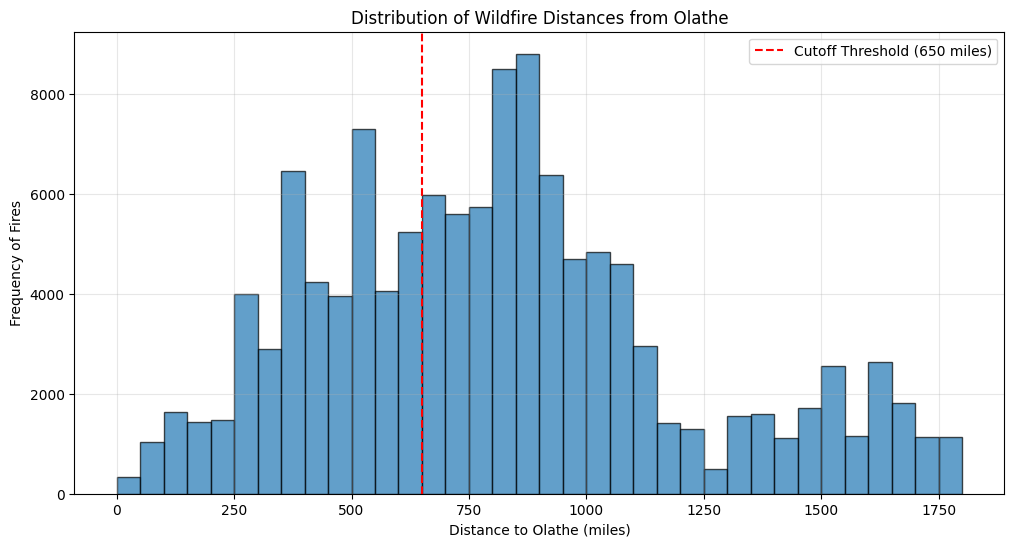

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from pyproj import Transformer, Geod
import geojson
import pandas as pd

# Initialize coordinate transformer for converting to EPSG:4326 and geodesic calculator
transform_to_wgs84 = Transformer.from_crs("ESRI:102008", "EPSG:4326")
geodesic_calculator = Geod(ellps='WGS84')

# Set analysis city location and distance threshold
location_coords = (33.53, -112.19)  # Glendale (latitude, longitude)
distance_threshold = 650  # miles for analysis

# Load wildfire data and calculate distances
fire_distances = []
with open('./USGS_Wildland_Fire_Combined_Dataset.json', 'r') as file:
    wildfire_data = geojson.load(file)
    
    for fire in wildfire_data['features']:
        try:
            # Extract perimeter coordinates from geometry
            perimeter = fire['geometry'].get('rings', []) or fire['geometry'].get('curveRings', [])
            if not perimeter:
                continue  # Skip if no perimeter data
                
            # Transform coordinates to WGS84 and store converted points
            transformed_coords = []
            for point in perimeter[0]:
                if len(point) >= 2:
                    latitude, longitude = transform_to_wgs84.transform(point[0], point[1])
                    transformed_coords.append((latitude, longitude))
            
            # Calculate distances from each point on perimeter to the city
            glendale_long, glendale_lat = location_coords[1], location_coords[0]
            distances_to_city = []
            for lat, lon in transformed_coords:
                _, _, distance_m = geodesic_calculator.inv(glendale_long, glendale_lat, lon, lat)
                distance_miles = distance_m * 0.000621371  # Convert meters to miles
                distances_to_city.append(distance_miles)
            
            # Keep the shortest distance for this fire if within maximum consideration range
            if distances_to_city:
                shortest_distance = min(distances_to_city)
                if shortest_distance <= 1800:
                    fire_distances.append(shortest_distance)
                    
        except Exception as e:
            print(f"Error processing fire data: {e}")
            continue

# Plot histogram of fire distances
plt.figure(figsize=(12, 6))
plt.hist(fire_distances, bins=np.arange(0, 1850, 50), edgecolor='black', alpha=0.7)
plt.axvline(x=distance_threshold, color='red', linestyle='--', label=f'Cutoff Threshold ({distance_threshold} miles)')
plt.title('Distribution of Wildfire Distances from Olathe')
plt.xlabel('Distance to Olathe (miles)')
plt.ylabel('Frequency of Fires')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# Visualization 2

Annual Total Acres Burned in Olathe

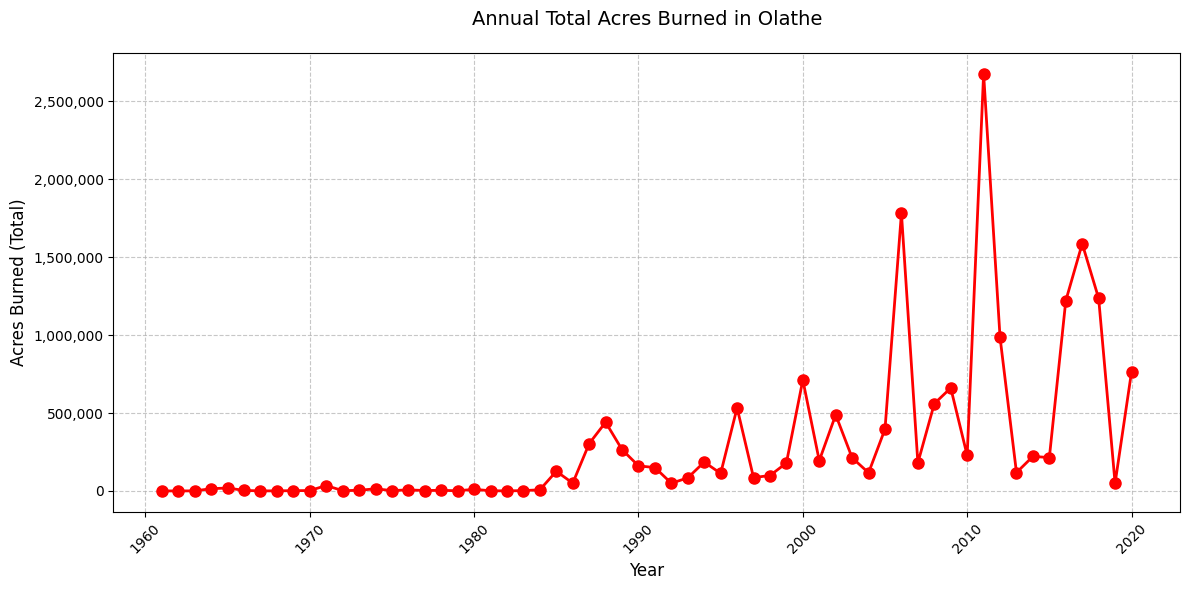

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the wildfire data for Olathe from CSV
olathe_fire_data = pd.read_csv("./fire_analysis_results/olathe_fire_impact_1961_2021.csv")

# Set up the figure size for the plot
plt.figure(figsize=(12, 6))

# Generate a line plot for total acres burned by year
plt.plot(olathe_fire_data['year'], olathe_fire_data['total_acres_burned'], marker='o', linewidth=2, markersize=8, color='red')

# Customize plot title and labels
plt.title('Annual Total Acres Burned in Olathe', fontsize=14, pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Acres Burned (Total)', fontsize=12)

# Format y-axis with comma separators for large numbers
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))

# Rotate x-axis labels for better alignment and readability
plt.xticks(rotation=45)

# Add grid lines for enhanced visual clarity
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout for optimal spacing
plt.tight_layout()

# Display the plot
plt.show()


# Visualization 3

Correlation between Smoke Impact Score and PM2.5 AQI in Olathe

Data Columns: Index(['Unnamed: 0', 'year', 'fire_impact_score', 'burned_acres',
       'total_data_days', 'avg_pm25', 'med_pm25', 'peak_pm25',
       'moderate_smoke_days', 'extreme_smoke_days', 'pm25_90th_percentile',
       'consecutive_high_pm25_days', 'composite_smoke_impact',
       'weighted_smoke_day_count'],
      dtype='object')


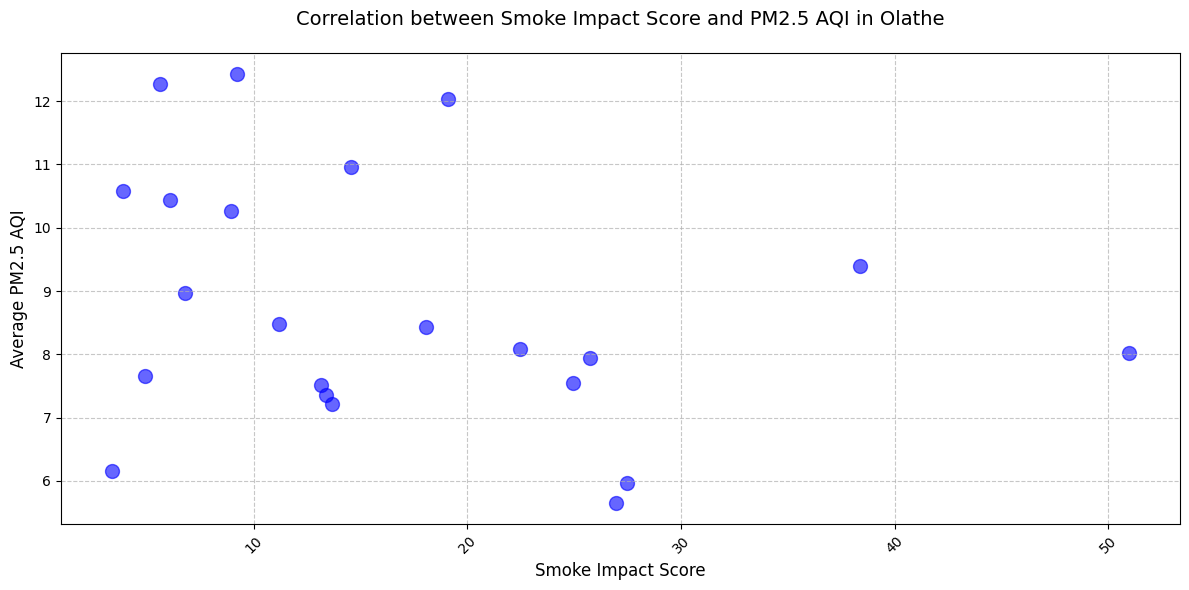

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Load AQI data for Olathe
olathe_aqi_data = pd.read_csv("./olathe_AQI.csv")
print("Data Columns:", olathe_aqi_data.columns)

# Set up the figure size for the scatter plot
plt.figure(figsize=(12, 6))

# Generate scatter plot to compare smoke impact score with mean PM2.5 AQI
plt.scatter(
    olathe_aqi_data['fire_impact_score'], 
    olathe_aqi_data['avg_pm25'],
    s=100,        # Marker size
    alpha=0.6,    # Marker transparency
    color='blue'
)

# Customize plot title and axis labels
plt.title('Correlation between Smoke Impact Score and PM2.5 AQI in Olathe', fontsize=14, pad=20)
plt.xlabel('Smoke Impact Score', fontsize=12)
plt.ylabel('Average PM2.5 AQI', fontsize=12)

# Format y-axis labels with commas for larger numbers
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y):,}'))

# Rotate x-axis labels for improved readability
plt.xticks(rotation=45)

# Add grid lines to the plot
plt.grid(visible=True, linestyle='--', alpha=0.7)

# Adjust layout for optimal spacing of plot elements
plt.tight_layout()

# Display the scatter plot
plt.show()


Relationship between Smoke Impact Score and Average PM2.5 in Olathe

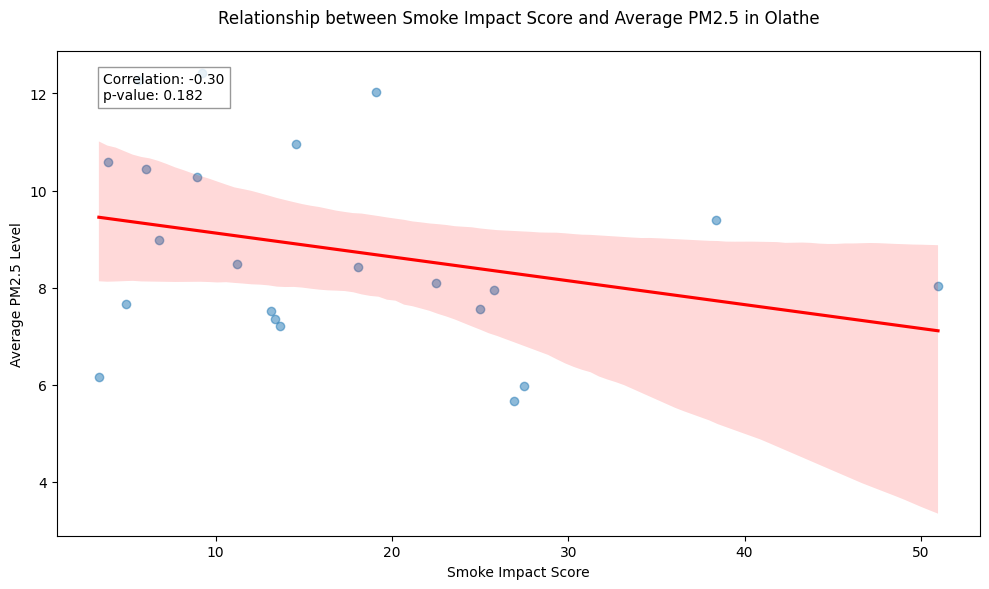

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Load AQI results for Olathe
olathe_aqi_results = pd.read_csv("./olathe_AQI.csv")

# Calculate the Pearson correlation coefficient and p-value
corr_coef, p_val = stats.pearsonr(olathe_aqi_results['fire_impact_score'], 
                                  olathe_aqi_results['avg_pm25'])

# Set up the figure size
plt.figure(figsize=(10, 6))

# Create scatter plot with a regression line
sns.regplot(
    data=olathe_aqi_results, 
    x='fire_impact_score', 
    y='avg_pm25', 
    scatter_kws={'alpha': 0.5}, 
    line_kws={'color': 'red'}
)

# Add title and axis labels
plt.title('Relationship between Smoke Impact Score and Average PM2.5 in Olathe', pad=20)
plt.xlabel('Smoke Impact Score')
plt.ylabel('Average PM2.5 Level')

# Display correlation coefficient and p-value on the plot
plt.text(0.05, 0.90, 
         f'Correlation: {corr_coef:.2f}\np-value: {p_val:.3f}', 
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8))

# Adjust layout for clear visualization and show plot
plt.tight_layout()
plt.show()


Forecasting future Smoke Impact Scores using an optimized ARIMA model


Model Evaluation Metrics:
MEAN_SQUARED_ERROR: 127.5059
ROOT_MEAN_SQUARED_ERROR: 11.2919
R2_SCORE: 0.0817
AIC: 177.1758
BIC: 181.5399
Optimal ARIMA Order (p, d, q): (1, 0, 1)

Predicted Smoke Impact Scores for Selected Years:
    year  predicted_impact_score
26  2025               17.972546
31  2030               16.599585
41  2040               16.759609
51  2050               16.762512


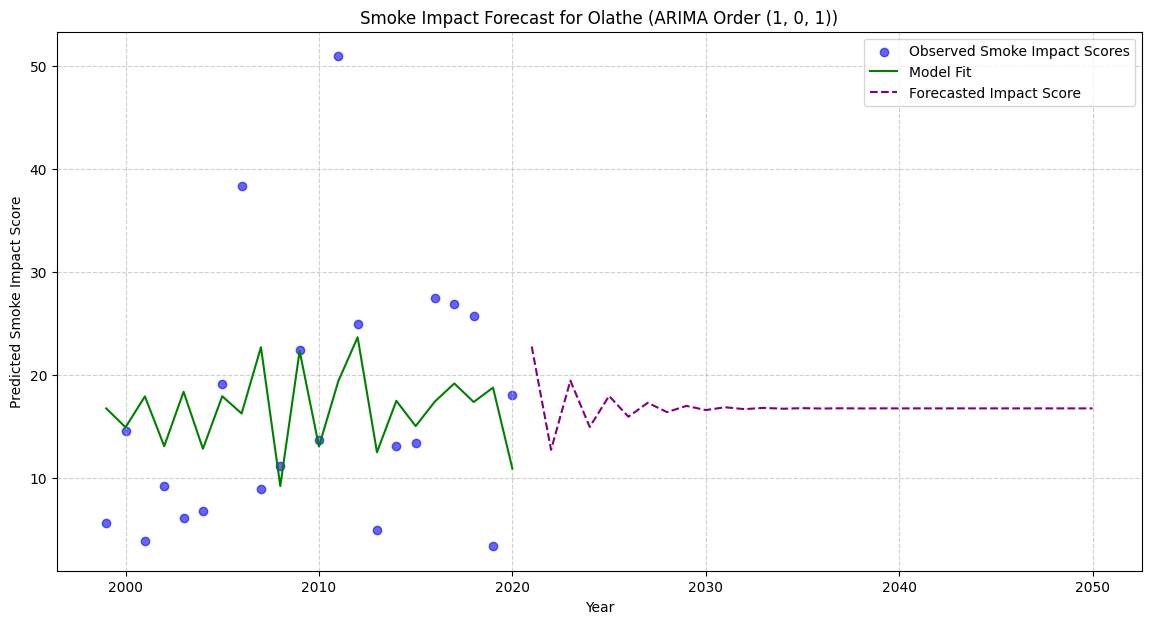

In [41]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from pmdarima import auto_arima

def project_smoke_impact(dataframe):
    """
    Project future Smoke Impact Scores using an optimized ARIMA model.
    
    Parameters:
    dataframe (pd.DataFrame): DataFrame containing 'year' and 'impact_score' columns.
    
    Returns:
    tuple: (forecast_data, evaluation_metrics, plot_object)
    """
    # Sort data by year to ensure chronological order
    sorted_data = dataframe.sort_values('year')
    
    # Use auto_arima to find the best (p, d, q) ARIMA parameters
    auto_arima_model = auto_arima(
        sorted_data['impact_score'],
        start_p=1, start_q=1,
        max_p=4, max_q=4,
        d=None,  # Let model decide differencing automatically
        seasonal=False,
        m=1, 
        stepwise=True,
        suppress_warnings=True,
        error_action='ignore'
    )
    
    # Extract the optimal order from the auto_arima model
    optimal_order = auto_arima_model.order
    
    # Fit ARIMA model using the identified order
    arima_model = ARIMA(sorted_data['impact_score'], order=optimal_order)
    fitted_model = arima_model.fit()
    
    # Predictions on historical data for model validation
    historical_fit = fitted_model.fittedvalues
    
    # Define forecast period (targeting 2050 as the endpoint)
    last_year = sorted_data['year'].max()
    forecast_horizon = 2050 - last_year
    
    # Generate forecasts
    forecast_values = fitted_model.forecast(steps=int(forecast_horizon))
    
    # Construct year array for both historical and forecasted data
    years_observed = sorted_data['year']
    years_projected = np.arange(last_year + 1, 2051)
    combined_years = np.concatenate([years_observed, years_projected])
    
    # Combine model predictions with historical fit
    combined_predictions = np.concatenate([historical_fit, forecast_values])
    
    # Create DataFrame with combined years and predictions
    forecast_data = pd.DataFrame({
        'year': combined_years,
        'predicted_impact_score': combined_predictions
    })
    
    # Model evaluation metrics for historical fit
    mse = mean_squared_error(sorted_data['impact_score'], historical_fit)
    rmse = np.sqrt(mse)
    r2 = r2_score(sorted_data['impact_score'], historical_fit)
    aic = fitted_model.aic
    bic = fitted_model.bic
    
    evaluation_metrics = {
        'mean_squared_error': mse,
        'root_mean_squared_error': rmse,
        'r2_score': r2,
        'aic': aic,
        'bic': bic,
        'best_arima_order': optimal_order
    }
    
    # Visualization: Historical data, model fit, and forecast
    plt.figure(figsize=(14, 7))
    
    # Plot actual historical data points
    plt.scatter(
        sorted_data['year'], 
        sorted_data['impact_score'], 
        color='blue', 
        label='Observed Smoke Impact Scores', 
        alpha=0.6
    )
    
    # Plot model's fit on historical data and future projections
    plt.plot(forecast_data[forecast_data['year'] <= last_year]['year'], 
             forecast_data[forecast_data['year'] <= last_year]['predicted_impact_score'], 
             color='green', label='Model Fit')
    
    plt.plot(forecast_data[forecast_data['year'] > last_year]['year'], 
             forecast_data[forecast_data['year'] > last_year]['predicted_impact_score'], 
             color='purple', linestyle='--', label='Forecasted Impact Score')
    
    # Customize plot aesthetics
    plt.xlabel('Year')
    plt.ylabel('Predicted Smoke Impact Score')
    plt.title(f'Smoke Impact Forecast for Olathe (ARIMA Order {optimal_order})')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    
    return forecast_data, evaluation_metrics, plt

# Example usage with example data
sample_years = list(olathe_results['year'])
sample_scores = list(olathe_results['fire_impact_score'])
dataframe = pd.DataFrame({
    'year': sample_years,
    'impact_score': sample_scores
})

# Run the smoke impact forecast function
forecast_data, model_metrics, forecast_plot = project_smoke_impact(dataframe)

# Print evaluation metrics
print("\nModel Evaluation Metrics:")
for metric, value in model_metrics.items():
    if metric != 'best_arima_order':
        print(f"{metric.upper()}: {value:.4f}")
    else:
        print(f"Optimal ARIMA Order (p, d, q): {value}")

# Display forecasted values for selected years
selected_years = [2025, 2030, 2040, 2050]
print("\nPredicted Smoke Impact Scores for Selected Years:")
print(forecast_data[forecast_data['year'].isin(selected_years)])
